# Setup

## Download the repo

In [19]:
# !git clone https://github.com/YuanGongND/ssast.git
!git clone https://github.com/roeizig/ssast.git

fatal: destination path 'ssast' already exists and is not an empty directory.


## Install requirements

In [1]:
!cd ssast/
!pip install -r /content/ssast/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Imports

In [2]:
import torch
import torchaudio
from PIL import Image
import numpy as np
from ssast.src.models.ast_models import *
from tqdm.notebook import tqdm_notebook
import time
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import output
output.enable_custom_widget_manager()

# output.disable_custom_widget_manager()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Overriding the model

## New model definition

In [3]:
from ssast.src.models.ast_models import ASTModel

class ASTModelRoei(ASTModel):
    def __init__(self):
      super().__init__(fshape=16, tshape=16, fstride=10, tstride=10, 
                      input_fdim=128, input_tdim=1024, model_size='tiny', 
                      pretrain_stage=False, load_pretrained_mdl_path='/content/ssast/pretrained_model/SSAST-Tiny-Patch-400.pth')
      # regressor head for fine-tuning / inference
      # self.regressor_head = nn.Sequential(nn.LayerNorm(self.original_embedding_dim),
      #                               nn.Linear(self.original_embedding_dim, 1))
      self.regressor_head = nn.Sequential(nn.LayerNorm(self.original_embedding_dim),
                                    nn.Linear(self.original_embedding_dim, 1))


    def finetuning_regressor(self, x, y):
        # Finetuning using the regressor task.
        # Calculate MSE loss and update weights accordingly
        # B = x.shape[0]

        # Calculate RMSE loss and update weights
        pred = self.regressor(x)
        target = y
        # If cannot use reference in a vectorized manner, use the for loop below
        # pred = torch.empty((B), device=x.device).float()  # e.g. size 12 for a batch of 12 spectrograms
        # target = torch.empty((B), device=x.device).float() # e.g. size 12 for a batch of 12 spectrograms
        # for i in range(B):
        #     #  +2 for indexes because of cls and dis token
        #     pred[i] = self.regressor(x[i])
        #     target[i] = y[i]
        # calculate the RMSE loss
        # rmse = torch.mean((pred - target) ** 2)**0.5

        # Update weights according to MSE loss
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        optimizer.zero_grad()
        criterion = nn.MSELoss()
        loss = criterion(pred, target)
        loss.backward()
        optimizer.step()

        return loss


    def regressor(self, x):
        # Copied from "finetuningavgtok"
        # changed only the last part, sending the intermediate result
        # to the regressor head instead of the mlp head.
        # Inference only mode
        B = x.shape[0]
        x = self.v.patch_embed(x)
        if self.cls_token_num == 2:
            cls_tokens = self.v.cls_token.expand(B, -1, -1)
            dist_token = self.v.dist_token.expand(B, -1, -1)
            x = torch.cat((cls_tokens, dist_token, x), dim=1)
        else:
            cls_tokens = self.v.cls_token.expand(B, -1, -1)
            x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.v.pos_embed
        x = self.v.pos_drop(x)

        for blk_id, blk in enumerate(self.v.blocks):
            x = blk(x)
        x = self.v.norm(x)

        # average output of all tokens except cls token(s)
        x = torch.mean(x[:, self.cls_token_num:, :], dim=1)
        x = self.regressor_head(x)
        return x


    def forward(self, x, task, y=None, cluster=True, mask_patch=400):
        # expect input x = (batch_size, time_frame_num, frequency_bins), e.g., (12, 1024, 128)
        x = x.unsqueeze(1)
        x = x.transpose(2, 3)

        # finetuning (ft), use the mean of all token (patch) output as clip-level representation.
        # this is default for SSAST fine-tuning as during pretraining, supervision signal is given to each token, not the [cls] token
        if task == 'ft_avgtok':
            return self.finetuningavgtok(x)
        # fine tuning the model as a regressor
        elif task == 'ft_regressor':
            return self.finetuning_regressor(x, y)
        # inference using a regressor
        elif task == 'regressor':
            return self.regressor(x)
        # alternatively, use the [cls] token output as clip-level representation.
        elif task == 'ft_cls':
            return self.finetuningcls(x)
        # pretraining, masked patch classification (discriminative objective)
        elif task == 'pretrain_mpc':
            return self.mpc(x, mask_patch=mask_patch, cluster=cluster)
        # pretraining, masked patch reconstruction (generative objective)
        elif task == 'pretrain_mpg':
            return self.mpg(x, mask_patch=mask_patch, cluster=cluster)
        elif task == 'visualize_mask':
            return self.mpc(x, mask_patch=mask_patch, cluster=cluster, show_mask=True)
        else:
            raise Exception('Task unrecognized.')



## Creating the overridden model

In [4]:
# new_model = ASTModelRoei()
# new_model.eval()
# new_model.to(device)

## Creating the dataset

In [5]:
## Creating Dataset
from random import sample
from torch.utils.data import Dataset, DataLoader
import os
import math
from torchvision import transforms


class SpectrogramData(Dataset):
    
    def __init__(self, audio_dir, device):
        self.audio_dir = audio_dir
        self.device = device
        self._create_ann()
        self.transform = transforms.PILToTensor()

        
    def __len__(self):
        return len(self.annotations[0])
        

    def __getitem__(self, index):
        sample_path = self._get_sample_path(index)
        label = float(self._get_sample_label(index))

        signal = Image.open(sample_path)
        signal = self.transform(signal)
        signal = signal.to(self.device, dtype=torch.float)
        return signal, label

            
    def _create_ann(self, path="ssast/spectrogram_images/"):
        Ann = [[],[],[]]
        for subdir, dirs, files in os.walk(path):
            for file in files:
                if file.endswith('png'):
                                Ann[0].append(file) ##name
                                Ann[1].append(subdir) #folder
                                tmp_label = file.split('_')[-1]
                                Ann[2].append(float(tmp_label[:-4])) #label
        Ann = np.asarray(Ann)
        self.annotations = Ann


    def shuffle(self):
      perm = torch.randperm(len(self.annotations[0]))
      self.annotations= self.annotations[:,perm]
      pass    
    

    def _get_sample_path(self, index):
        folder = self.annotations[1][index]
        filename = self.annotations[0][index]
        path = os.path.join(self.audio_dir, folder, filename)
        return path
    

    def _get_sample_label(self, index):
        label = self.annotations[2][index]
        return label

##Functuins for DataViz
    def _index_from_label(self, query_label):
        labels =[float(x) for x in self.annotations[2]]
        query_label = np.asarray(query_label)
        index = (np.abs(labels-query_label)).argmin()
        return index
        
    def seq_from_label(self, query, query_type = 'label'):
        
        if query_type == 'label':
          index = self._index_from_label(query)
        else:
          index = query
        folder = self.annotations[1][index]
        current_call_filename = self.annotations[0][index]
        
        current_call_path = self._get_sample_path(index)
        current_call =Image.open(current_call_path)
        
        current_call_num = int(current_call_filename.split('_')[-3])
        prefix = '_'.join(current_call_filename.split('_')[:-3])

        next_call_prefix = '_'.join([prefix, str(current_call_num+1)])+'_'
        prev_call_prefix = '_'.join([prefix, str(current_call_num-1)])+'_'
        
      
        next_call_filename= None
        prev_call_filename = None
        next_call = None
        prev_call = None
      
        for subdir, dirs, files in os.walk(folder):
          for file in files:
              if file.startswith(bytes(next_call_prefix,'utf-8')):
                              next_call_filename = file.decode()
                              next_call_path = os.path.join(folder, next_call_filename)
                              next_call = Image.open(next_call_path)
              if file.startswith(bytes(prev_call_prefix,'utf-8')):
                              prev_call_filename = file.decode()
                              prev_call_path = os.path.join(folder, prev_call_filename)
                              prev_call = Image.open(prev_call_path)
        
        images = [prev_call, current_call, next_call]
        names  = [prev_call_filename, current_call_filename, next_call_filename]

        for i, (img,name) in enumerate(zip(images, names)):
          if img:
            img = img.transpose(Image.FLIP_TOP_BOTTOM)
            plt.imshow(img, origin = 'lower')
            plt.title(name)
            plt.show()
          else:
            if i == 0:
              print(f'previous call does not exist')
            else:
              print(f'next call does not exist')

        return images, names




In [6]:
path = "ssast/spectrogram_images/"
x = SpectrogramData("", device)
trainval , testset = torch.utils.data.random_split(x, [3000, len(x)-3000],
                                            generator=torch.Generator().manual_seed(42))
trainset, valset = torch.utils.data.random_split(trainval, [2000, 1000],
                                                generator=torch.Generator().manual_seed(42))

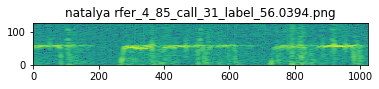

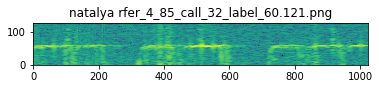

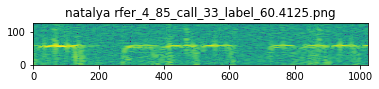

In [7]:
##Testing the sequence display
label = 52.2493
label = 60
images, names = x.seq_from_label(label)

## Testing the model on a single spectrogram

In [ ]:
# xx = x[1]
# pred = new_model(xx[0], task='regressor')
# label = xx[-1]
# print(pred)
# print(label)

In [ ]:
# new_model(spectgram.unsqueeze(0).to(dtype=torch.float), task='ft_regressor', y=torch.Tensor([[float(xx[-1])]]))

# Training the Model

In [8]:
batch_size = 16
trainloader = DataLoader(trainset, batch_size=batch_size,
                            shuffle=True, num_workers=0)
valloader = DataLoader(valset, batch_size=batch_size,
                        shuffle=True, num_workers=0)


In [ ]:
# torch.cuda.empty_cache()

In [13]:
def train_loop(trainloader, valloader, model, epochs = 30):
  model = model.to(device)
  train_losses, val_losses = [], []
  train_accs, val_accs = [], []
  for e in range(epochs):
      running_loss = 0
      train_correct = 0
      model.train()
      for images, labels in tqdm_notebook(trainloader):

          images = images.to(device, dtype=torch.float)
          labels = labels.to(device, dtype=torch.float)
          loss = model(images.squeeze(1), task='ft_regressor', y=labels.unsqueeze(-1))
          loss = loss.item()
          # print(loss)
          running_loss += loss
          
          # ##evaluating without dropout
          # with torch.no_grad():
          #   model.eval()
          #   logits = model(images.to(device))
          #   ps = torch.softmax(logits,dim=1)
          #   top_ps, top_class = ps.topk(1,dim=1)
          #   train_equals_batch = top_class == (labels.view(*top_class.shape))
          #   train_correct +=train_equals_batch.sum().item()
          
          # model.train()
          
          
      else:
          running_val_loss = 0
          val_correct = 0
          
          with torch.no_grad():
              model.eval()
              for images, labels in tqdm_notebook(valloader):  
                  images = images.to(device, dtype=torch.float)
                  labels = labels.to(device, dtype=torch.float)
                  pred = model(images.squeeze(1), task='regressor', y=labels.unsqueeze(-1))
                  criterion = nn.MSELoss()
                  loss = criterion(pred, labels.unsqueeze(-1).to(device, dtype = float))
                  loss = loss.item()
                  running_val_loss += loss

                  # ps = torch.softmax(logits, dim=1)
                  # top_ps, top_class = ps.topk(1,dim=1)
                  # equals_batch = top_class == labels.view(*top_class.shape)
                  # test_correct +=equals_batch.sum().item()
              model.train()
          
          training_loss = running_loss/len(trainloader)
          val_loss = running_val_loss/len(valloader)
          train_accuracy = 0 # train_correct/len(trainloader.dataset)
          val_accuracy = 0 #test_correct/len(testloader.dataset)
          if e>0:
            if val_loss<min(val_losses):
              print('saving model...')
              torch.save(model.state_dict(),'model.pth')

          
          train_losses.append(training_loss)
          val_losses.append(val_loss)
          train_accs.append(train_accuracy)
          val_accs.append(val_accuracy)
          print("Epoch: {}/{}.. ".format(e+1, epochs),
                "Training Loss: {:.3f}.. ".format(training_loss),
                "Test Loss: {:.3f}.. ".format(val_loss))
  return train_losses, train_accs, val_losses, val_accs  

In [14]:
new_model = ASTModelRoei()
new_model.to(device)
trainloss,trainacc,valloss,valacc = train_loop(trainloader, valloader, model = new_model, epochs = 30)


now load a SSL pretrained models from /content/ssast/pretrained_model/SSAST-Tiny-Patch-400.pth
pretraining patch split stride: frequency=16, time=16
pretraining patch shape: frequency=16, time=16
pretraining patch array dimension: frequency=8, time=64
pretraining number of patches=512
fine-tuning patch split stride: frequncey=10, time=10
fine-tuning number of patches=1212


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 1/30..  Training Loss: 1089.486..  Test Loss: 252.209.. 


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

saving model...
Epoch: 2/30..  Training Loss: 51.923..  Test Loss: 24.692.. 


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

saving model...
Epoch: 3/30..  Training Loss: 16.905..  Test Loss: 8.342.. 


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

saving model...
Epoch: 4/30..  Training Loss: 13.906..  Test Loss: 7.356.. 


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 5/30..  Training Loss: 12.492..  Test Loss: 7.471.. 


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 6/30..  Training Loss: 11.278..  Test Loss: 7.775.. 


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 7/30..  Training Loss: 10.373..  Test Loss: 8.015.. 


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 8/30..  Training Loss: 10.751..  Test Loss: 8.570.. 


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 9/30..  Training Loss: 9.773..  Test Loss: 8.735.. 


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 10/30..  Training Loss: 9.512..  Test Loss: 23.129.. 


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

saving model...
Epoch: 11/30..  Training Loss: 9.912..  Test Loss: 6.477.. 


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

saving model...
Epoch: 12/30..  Training Loss: 9.663..  Test Loss: 5.992.. 


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 13/30..  Training Loss: 8.863..  Test Loss: 6.165.. 


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 14/30..  Training Loss: 8.804..  Test Loss: 7.280.. 


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 15/30..  Training Loss: 8.385..  Test Loss: 7.600.. 


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 16/30..  Training Loss: 8.180..  Test Loss: 6.217.. 


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 17/30..  Training Loss: 8.431..  Test Loss: 7.054.. 


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 18/30..  Training Loss: 9.885..  Test Loss: 8.599.. 


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 19/30..  Training Loss: 8.697..  Test Loss: 6.511.. 


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 20/30..  Training Loss: 8.137..  Test Loss: 7.897.. 


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 21/30..  Training Loss: 7.956..  Test Loss: 8.437.. 


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 22/30..  Training Loss: 7.901..  Test Loss: 7.172.. 


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 23/30..  Training Loss: 8.173..  Test Loss: 7.567.. 


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

saving model...
Epoch: 24/30..  Training Loss: 7.813..  Test Loss: 5.150.. 


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 25/30..  Training Loss: 7.546..  Test Loss: 6.007.. 


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 26/30..  Training Loss: 7.809..  Test Loss: 5.442.. 


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 27/30..  Training Loss: 7.748..  Test Loss: 6.023.. 


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

saving model...
Epoch: 28/30..  Training Loss: 7.780..  Test Loss: 5.075.. 


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 29/30..  Training Loss: 7.552..  Test Loss: 8.856.. 


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 30/30..  Training Loss: 9.399..  Test Loss: 6.870.. 


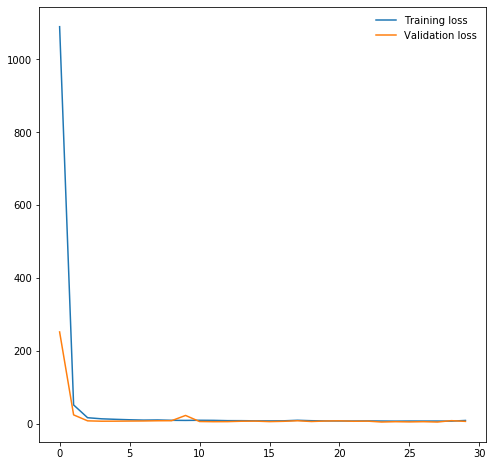

In [15]:
plt.figure(figsize = (8,8))
plt.plot(trainloss,label = 'Training loss')
plt.plot(valloss,label = 'Validation loss')
plt.legend(frameon=False)


In [ ]:
torch.cuda.empty_cache()
!nvidia-smi

In [ ]:
# Save the model itself
# torch.save(new_model, 'model_30e_clean.pth')

# Save the model's weights
# torch.save(new_model.state_dict(), 'model_weights_30e_clean.pth')

In [ ]:
# plt.figure(figsize = (8,8))
# plt.plot(trainloss,label = 'Training loss')
# plt.plot(valloss,label = 'Validation loss')
# plt.legend(frameon=False)

# # plt.figure(figsize = (8,8))
# # plt.plot(train_accs_d,label = 'Training Accuracy')
# # plt.plot(test_accs_d,label = 'Validation Accuracy')
# # plt.legend(frameon=False)

# Load an existing model

In [82]:
new_model = ASTModelRoei()
new_model.load_state_dict(torch.load('/content/ssast/pretrained_model/model_weights_30e_cleanV1.pth'))
new_model.eval()
new_model.to(device)

now load a SSL pretrained models from /content/ssast/pretrained_model/SSAST-Tiny-Patch-400.pth
pretraining patch split stride: frequency=16, time=16
pretraining patch shape: frequency=16, time=16
pretraining patch array dimension: frequency=8, time=64
pretraining number of patches=512
fine-tuning patch split stride: frequncey=10, time=10
fine-tuning number of patches=1212


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


ASTModelRoei(
  (v): DistilledVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(1, 192, kernel_size=(16, 16), stride=(10, 10))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=192, out_features=576, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=192, out_features=192, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=192, out_features=768, bias=True)
          (act): GELU()
          (fc2): Linear(in_features=768, out_features=192, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
      (1): Block(
        (norm1): LayerNorm((19

# Analyze results

## Functions

In [83]:
def get_sample_results(model, dataset):
    data_size = len(dataset.indices)
    if data_size < 256:
        dataloader = DataLoader(dataset, batch_size=data_size,
                                shuffle=True, num_workers=0)
        images, labels = next(iter(dataloader))
        with torch.no_grad():
            model.eval()
            preds = model(images.squeeze(1).to(device, dtype=torch.float), task='regressor')
            diff = preds.squeeze().cpu() - labels.squeeze().cpu()
            rmse = torch.sqrt(torch.mean(torch.square(diff)))
    else:
        batch_size = 256
        dataloader = DataLoader(dataset, batch_size=batch_size,
                                shuffle=True, num_workers=0)
        labels = torch.tensor((), device=device)
        preds = torch.tensor((), device=device)
        diff = torch.tensor(())
        with torch.no_grad():
            model.eval()
            for batch_images, batch_labels in dataloader:
                batch_images = batch_images.to(device, dtype=torch.float)
                batch_labels = batch_labels.to(device, dtype=torch.float)
                batch_preds = model(batch_images.squeeze(1), task='regressor')
                batch_diff = batch_preds.squeeze().cpu() - batch_labels.squeeze().cpu()
                labels = torch.cat([labels, batch_labels], dim=0)
                preds = torch.cat([preds, batch_preds], dim=0)
                diff = torch.cat([diff, batch_diff], dim=0)
            rmse = torch.sqrt(torch.mean(torch.square(diff)))
    print(f"Dataset RMSE is {rmse:.2f}")
    return pd.DataFrame({'pred': preds.cpu().squeeze(), 
                         'label': labels.cpu().squeeze(), 
                         'diff' :diff, 
                         'abs_diff': diff.abs()})

In [84]:
def analyze_sample_results(stats_df):
    # Scatter plot with linear trend y=x
    lin_min = np.min([stats_df['pred'].min(), stats_df['label'].min()])
    lin_max = np.max([stats_df['pred'].max(), stats_df['label'].max()])
    plt.figure(figsize=(15, 9))
    plt.scatter(stats_df['label'], stats_df['pred'])
    plt.plot([lin_min, lin_max], [lin_min, lin_max], color='red')
    plt.title("Model prediction vs. label", size=18)
    plt.xlabel("Label", size=16)
    plt.ylabel("Prediction", size=16)
    plt.show()

    # Error histogram
    plt.figure(figsize=(15, 9))
    plt.hist(stats_df['diff'], bins=100)
    plt.title("Model's error distribution", size=18)
    plt.xlabel("Error", size=16)
    plt.ylabel("Amount", size=16)
    plt.show()


    # label histogram
    plt.figure(figsize=(15, 9))
    plt.hist(stats_df['label'], bins=100)
    plt.title("GT distribution", size=18)
    plt.xlabel("label", size=16)
    plt.ylabel("Amount", size=16)
    plt.show()

    # Diff statistics
    display(stats_df.describe([.1, .25, .5, .75, .9])[['abs_diff']].T)

## Test analysis

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:165: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  img = torch.as_tensor(np.asarray(pic))


Dataset RMSE is 2.20


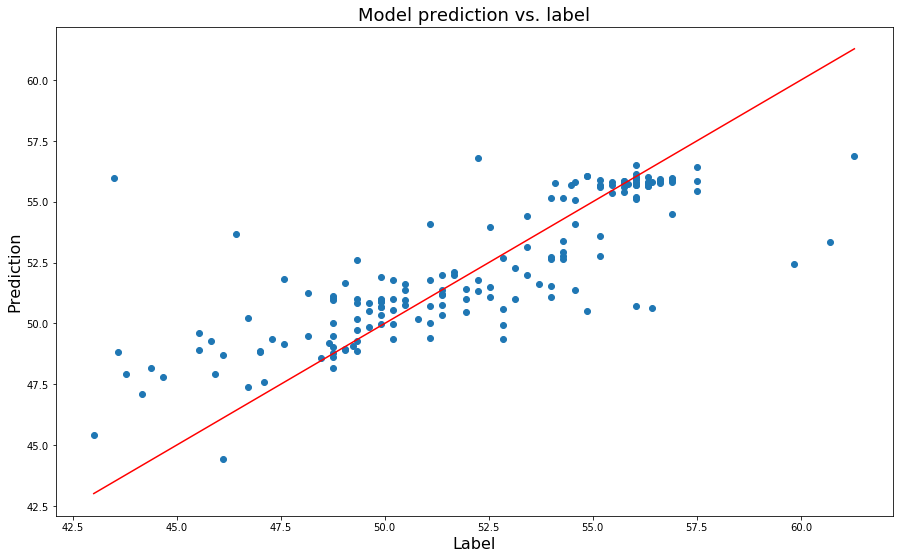

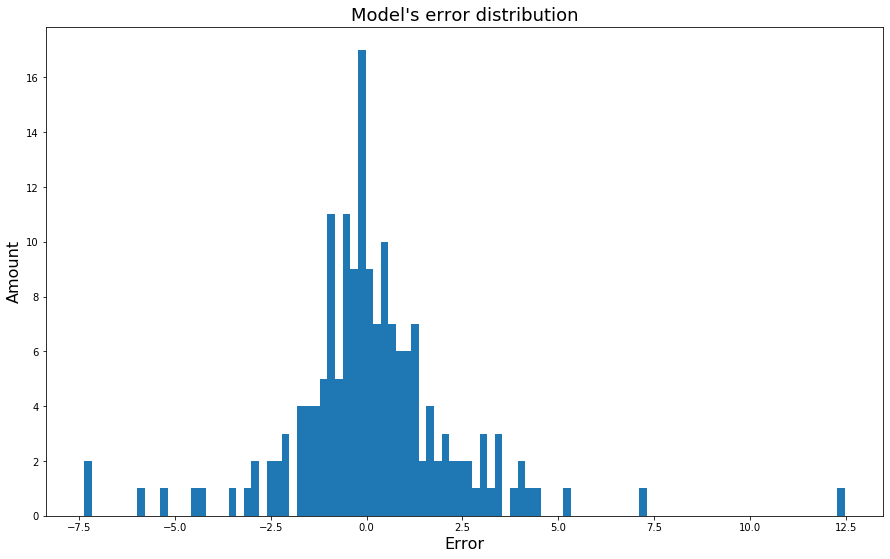

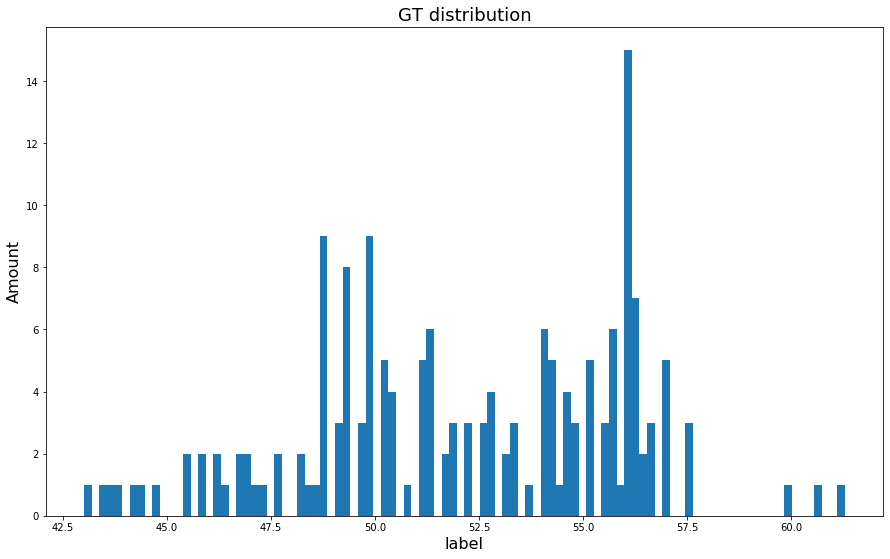

,count,mean,std,min,10%,25%,50%,75%,90%,max
abs_diff,172.0,1.444189,1.669972,0.014133,0.129387,0.427111,0.930632,1.848519,3.358989,12.475322


In [85]:
test_df = get_sample_results(new_model, testset)
analyze_sample_results(test_df)
torch.cuda.empty_cache()

## Train & Validation analysis

Dataset RMSE is 2.37


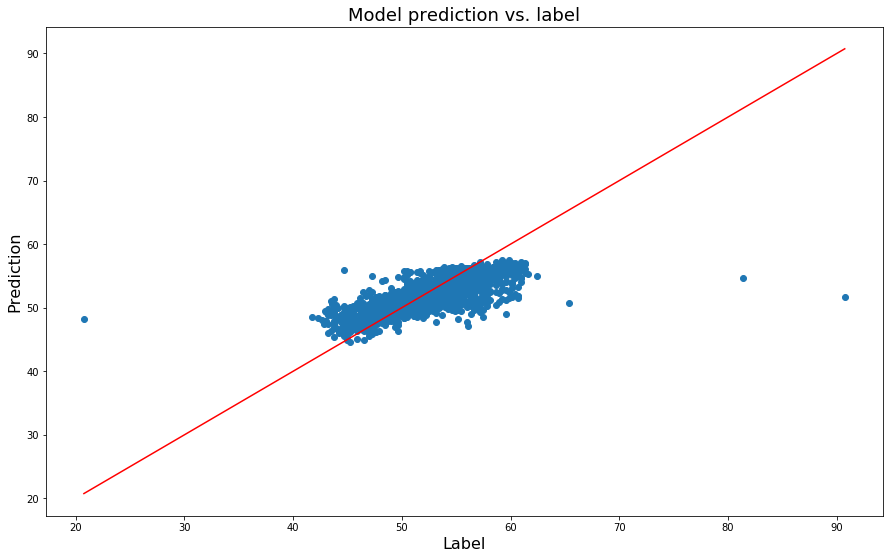

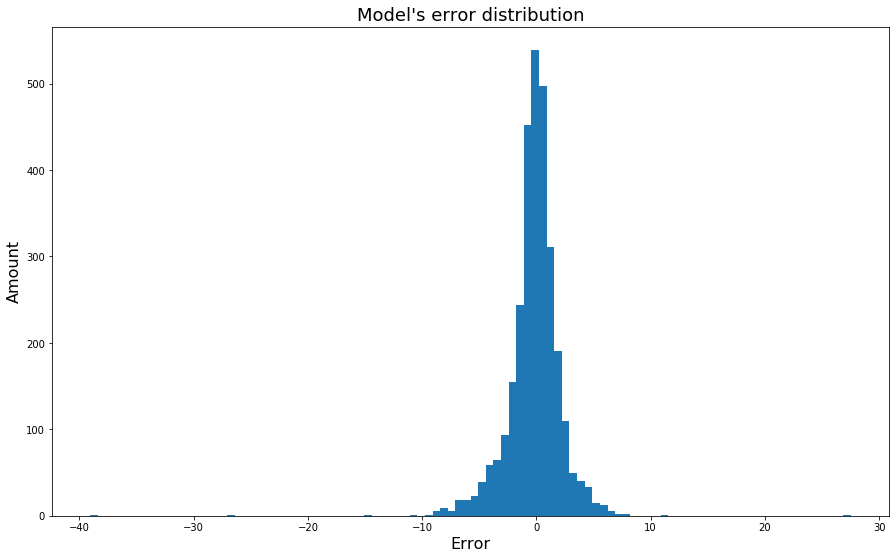

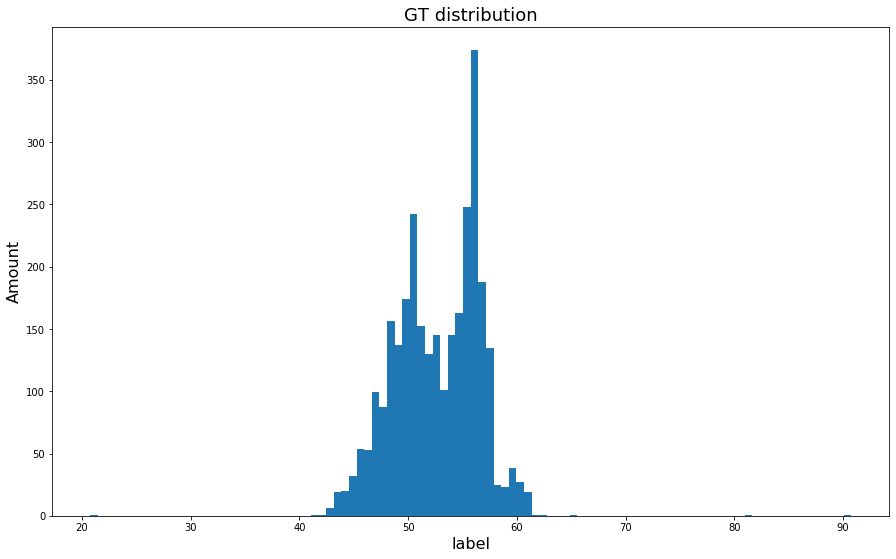

,count,mean,std,min,10%,25%,50%,75%,90%,max
abs_diff,3000.0,1.5404,1.798566,0.000019,0.186418,0.465614,1.012579,2.012798,3.624747,39.060341


In [86]:
trainval_df = get_sample_results(new_model, trainval)
analyze_sample_results(trainval_df)
torch.cuda.empty_cache()

## Find samples of largest error

 Search "label_{label}" in images folder for the actual image

In [ ]:
(pd.concat([trainval_df,
           test_df],
          axis=0)
.sort_values('abs_diff', ascending=False).head(10))

,pred,label,diff,abs_diff
1390,51.672859,90.733200,-39.060341,39.060341
155,48.299709,20.762400,27.537310,27.537310
1459,54.668934,81.403801,-26.734867,26.734867
535,50.816032,65.368797,-14.552765,14.552765
100,55.978222,43.502900,12.475322,12.475322
1245,56.011433,44.669102,11.342331,11.342331
1589,49.077621,59.546700,-10.469078,10.469078
354,51.470219,60.704102,-9.233883,9.233883
2897,48.591267,57.497101,-8.905834,8.905834
2509,47.154518,56.044701,-8.890182,8.890182


# Display sequences of largest errors


In [16]:
for row in (pd.concat([trainval_df, test_df], axis=0).sort_values('abs_diff', ascending=False).head(5)).iterrows():
    print(f"Error of {row[1]['diff']:.2f}")
    print("3-Sequence of the respective images:")
    x.seq_from_label(row[1]['label'])
    print()

NameError: ignored